In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [0]:
# Read Files
def read_textfile(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [0]:
# Split
def to_lines(text):
    sentences = text.strip().split('\n')
    sentences = [s.split('\t') for s in sentences]
    return sentences

In [0]:
data = read_textfile("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:60000,:]

In [0]:
# Removing Punctuation
deu_eng[:,0] = [sent.translate(str.maketrans('', '', string.punctuation)) for sent in deu_eng[:,0]]
deu_eng[:,1] = [sent.translate(str.maketrans('', '', string.punctuation)) for sent in deu_eng[:,1]]

In [0]:
# Lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [0]:
# empty lists
eng_l = []
ger_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    ger_l.append(len(i.split()))

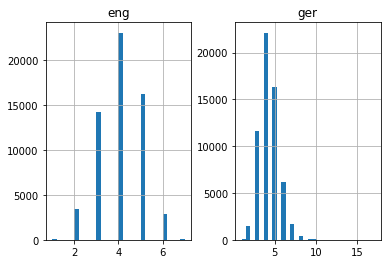

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'ger':ger_l})
length_df.hist(bins = 30)
plt.show()

In [0]:
# Tokenizer
def token(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# English tokenizer
eng_tokenizer = token(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7049


In [16]:
# German tokenizer
deu_tokenizer = token(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('German Vocabulary Size: %d' % deu_vocab_size)

German Vocabulary Size: 12113


In [0]:
#Padding Sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:
#Model Building and Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 10)

In [0]:
#Training Data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [0]:
# Validation Data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# RNN Model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [22]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0811 10:20:58.071575 140573390124928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:20:58.117448 140573390124928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:20:58.127386 140573390124928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:20:59.085262 140573390124928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

In [23]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

W0811 10:21:12.980399 140573390124928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 15s 379us/step - loss: 3.6089 - val_loss: 3.0974

Epoch 00001: val_loss improved from inf to 3.09736, saving model to model.h1
Epoch 2/30
38400/38400 [==============================] - 9s 238us/step - loss: 2.9997 - val_loss: 2.9725

Epoch 00002: val_loss improved from 3.09736 to 2.97255, saving model to model.h1
Epoch 3/30
38400/38400 [==============================] - 9s 239us/step - loss: 2.7832 - val_loss: 2.7775

Epoch 00003: val_loss improved from 2.97255 to 2.77748, saving model to model.h1
Epoch 4/30
38400/38400 [==============================] - 9s 240us/step - loss: 2.6124 - val_loss: 2.6123

Epoch 00004: val_loss improved from 2.77748 to 2.61232, saving model to model.h1
Epoch 5/30
38400/38400 [==============================] - 9s 239us/step - loss: 2.4552 - val_loss: 2.4802

Epoch 00005: val_loss improved from 2.61232 to 2.48019, saving model to model.h1
Epoch 6/30
384

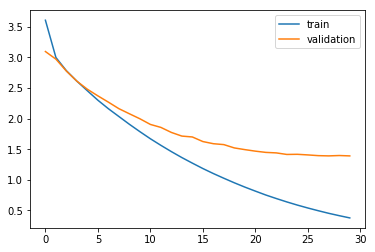

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [39]:
pred_df.sample(15)

,actual,predicted
5997,stop bothering me,stop bothering me
10794,is this love,is this love
11436,wheres my phone book,wheres my
3844,your shoes are here,your shoes are here
7592,i knew youd get it,i knew youd get it
10826,i never eat meat,i could eat
1017,why did you wake me up,why did you wake me up
7477,tom is walking south,tom is going in bed
4511,tom disagreed,tom objected
5020,tom was gone,tom was
